# CSCN8000 –Artificial Intelligence Algorithms and Mathematics
<br>
Name       : Khushbu Nileshkumar Lad<br>
Student No : 9027375

## Assignment 3

## Part 1: Model Training and Evaluation

##### Import libraries

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, classification_report
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np


##### Load dataset

In [3]:
stroke_dataset = pd.read_csv("./Dataset/stroke.csv")
stroke_dataset.head(2)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1


### Data Preprocessing

#### a. Fill in the missing values in numerical/categorical columns with an appropriate way

Check missing values

In [4]:
## Check null values in columns
print(stroke_dataset.isnull().sum())

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64


Null values are found only in column "bmi", so validating distribution of this column to fill missing values

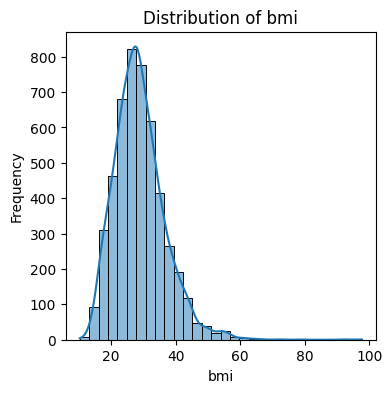

In [5]:
column_name = 'bmi'

# Histogram
plt.figure(figsize=(4, 4))
sns.histplot(stroke_dataset[column_name], kde=True, bins=30)
plt.title(f'Distribution of {column_name}')
plt.xlabel(column_name)
plt.ylabel('Frequency')
plt.show()


In [6]:
print(stroke_dataset['bmi'].describe())
print(f"mean   : {stroke_dataset['bmi'].mean()}")
print(f"median : {stroke_dataset['bmi'].median()}")
print(f"mode   : {stroke_dataset['bmi'].mode()}")

count    4909.000000
mean       28.893237
std         7.854067
min        10.300000
25%        23.500000
50%        28.100000
75%        33.100000
max        97.600000
Name: bmi, dtype: float64
mean   : 28.893236911794666
median : 28.1
mode   : 0    28.7
Name: bmi, dtype: float64


BMI data is **right skewed**, so null values can be replaced by **median** as median is **less affected by outliers**. 

In [7]:
stroke_dataset['bmi'] = stroke_dataset['bmi'].fillna(stroke_dataset['bmi'].median())


#### b. Encode the categorical features using categorical encoding

In [8]:
categorical_columns = stroke_dataset.select_dtypes(include=['object', 'category'])
for col in categorical_columns.columns:
    print(f"Unique values in column '{col}':")
    print(categorical_columns[col].unique())
    print()  

Unique values in column 'gender':
['Male' 'Female' 'Other']

Unique values in column 'ever_married':
['Yes' 'No']

Unique values in column 'work_type':
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']

Unique values in column 'Residence_type':
['Urban' 'Rural']

Unique values in column 'smoking_status':
['formerly smoked' 'never smoked' 'smokes' 'Unknown']



Observing unique values, apply following encoding to above columns
<br>
<br>
***Label encoding***
1. gender
2. ever_married
3. Residence_type
4. work_type 

***One hot encoding***
1. smoking_status

In [9]:
label_encoder = LabelEncoder()

# Apply Label Encoding
for col in ['gender', 'ever_married', 'Residence_type', 'work_type']:
    stroke_dataset[col] = label_encoder.fit_transform(stroke_dataset[col])

# Apply One-Hot Encoding for 'smoking_status'
stroke_dataset = pd.get_dummies(stroke_dataset, columns=['smoking_status'], prefix='smoking_status')

In [10]:
# Display the transformed dataset
stroke_dataset.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,stroke,smoking_status_Unknown,smoking_status_formerly smoked,smoking_status_never smoked,smoking_status_smokes
0,9046,1,67.0,0,1,1,2,1,228.69,36.6,1,False,True,False,False
1,51676,0,61.0,0,0,1,3,0,202.21,28.1,1,False,False,True,False
2,31112,1,80.0,0,1,1,2,0,105.92,32.5,1,False,False,True,False
3,60182,0,49.0,0,0,1,2,1,171.23,34.4,1,False,False,False,True
4,1665,0,79.0,1,0,1,3,0,174.12,24.0,1,False,False,True,False


## ML Model Training and Testing Tasks

##### 1. Split the processed data into training and testing sets (e.g., 80% training, 20% testing).

In [11]:
X = stroke_dataset.drop(columns=['stroke'])  # Features
y = stroke_dataset['stroke']  # Target variable

# Split the data into training and testing sets (80%-20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Training set size: (4088, 14)
Testing set size: (1022, 14)


##### 2. Train the MLP model on the training set, however you need to do a comparison between the performance of the model on a validation set (with cross-validation) using different hyperparameter values:
1. Need to try out 10 different overall variations of number of layers and number of neurons per layer. For example one variation could be 2 hidden layers with 64 neurons in first and 32 in second.
2. Need to try out at least 3 different learning rate values.
3. Note: The GridSearchCV function in sklearn could help with that.

##### Standardize the data for MLP

In [12]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

##### MLP Classifier

In [13]:
mlp = MLPClassifier(max_iter=1000, random_state=42)
param_grid = {
    'hidden_layer_sizes': [
        (32,), (64,), (128,),  # Single hidden layers with 32, 64, and 128 neurons
        (64, 32), (128, 64), (256, 128),  # Two hidden layers with different neurons
        (64, 64), (128, 128), (256, 256),  # Equal sized two layers with increasing neurons
        (64, 64, 32), (128, 64, 32)  # Three hidden layers with decreasing neurons
    ],
    'learning_rate_init': [0.0001, 0.001, 0.01],
}

grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)

In [14]:
grid_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 33 candidates, totalling 165 fits
[CV] END hidden_layer_sizes=(32,), learning_rate_init=0.0001; total time=   1.9s
[CV] END hidden_layer_sizes=(32,), learning_rate_init=0.0001; total time=   1.7s
[CV] END hidden_layer_sizes=(32,), learning_rate_init=0.0001; total time=   1.7s
[CV] END hidden_layer_sizes=(32,), learning_rate_init=0.0001; total time=   1.7s
[CV] END hidden_layer_sizes=(32,), learning_rate_init=0.0001; total time=   1.6s
[CV] END .hidden_layer_sizes=(32,), learning_rate_init=0.001; total time=   3.3s
[CV] END .hidden_layer_sizes=(32,), learning_rate_init=0.001; total time=   4.1s
[CV] END .hidden_layer_sizes=(32,), learning_rate_init=0.001; total time=   2.9s
[CV] END .hidden_layer_sizes=(32,), learning_rate_init=0.001; total time=   3.1s
[CV] END .hidden_layer_sizes=(32,), learning_rate_init=0.001; total time=   4.8s
[CV] END ..hidden_layer_sizes=(32,), learning_rate_init=0.01; total time=   1.1s
[CV] END ..hidden_layer_sizes=(32,), learning_r

d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .hidden_layer_sizes=(64,), learning_rate_init=0.001; total time=  13.4s
[CV] END ..hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   1.4s
[CV] END ..hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   1.0s
[CV] END ..hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   1.6s
[CV] END ..hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   4.2s
[CV] END ..hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   3.9s
[CV] END hidden_layer_sizes=(128,), learning_rate_init=0.0001; total time=   5.7s
[CV] END hidden_layer_sizes=(128,), learning_rate_init=0.0001; total time=   5.2s
[CV] END hidden_layer_sizes=(128,), learning_rate_init=0.0001; total time=   5.9s
[CV] END hidden_layer_sizes=(128,), learning_rate_init=0.0001; total time=   6.4s
[CV] END hidden_layer_sizes=(128,), learning_rate_init=0.0001; total time=   4.3s
[CV] END hidden_layer_sizes=(128,), learning_rate_init=0.001; total time=  23.8s
[CV] END hidden_layer_s

d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.0001; total time=  24.6s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.0001; total time=  28.8s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.0001; total time=  32.2s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.0001; total time=  25.0s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.0001; total time=  25.8s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.001; total time=   4.8s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.001; total time=   7.2s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.001; total time=  12.1s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.001; total time=   6.8s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.001; total time=   7.1s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.01; total time=   2.8s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.01; total time=   1.6s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.01; total time=   2.6s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.01; total time=   1.9s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.01; total time=   1.7s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.0001; total time= 1

d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.0001; total time=  51.8s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.0001; total time=  46.5s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.0001; total time=  53.7s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.001; total time=   8.2s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.001; total time=  10.8s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.001; total time=   8.3s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.001; total time=  12.6s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.001; total time=   8.7s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.01; total time=   3.5s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.01; total time=   6.2s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.01; total time=   3.5s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.01; 

d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.0001; total time=  14.8s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.0001; total time=  28.7s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.0001; total time=  14.1s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.0001; total time=  13.5s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.0001; total time=  13.9s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.001; total time=  12.2s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.001; total time=  13.2s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.001; total time=   4.8s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.001; total time=   4.5s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.001; total time=   9.1s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.01; total time=   2.6s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.01; total time=   2.6s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.01; total time=   2.3s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.01; total time=   2.6s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.01; total time=   1.1s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.0001; total time=  36.3s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.0001; total time=  35.9s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.0001; total time=  39.1s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.0001; total time= 1.3min


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.0001; total time= 1.4min
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.001; total time=  15.4s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.001; total time=  15.9s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.001; total time=  16.8s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.001; total time=   9.7s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.001; total time=   8.7s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.01; total time=   2.5s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.01; total time=   3.8s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.01; total time=   2.3s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.01; total time=   3.1s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.01; total time=   1.8s
[CV] END hidden_layer_sizes=(256, 256), learning_rate_init=0.0001; to

d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.0001; total time=  17.3s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.0001; total time=  19.2s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.0001; total time=  17.0s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.0001; total time=  17.8s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.0001; total time=  17.4s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.001; total time=   2.9s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.001; total time=   3.0s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.001; total time=   2.5s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.001; total time=   2.8s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.001; total time=   2.1s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.01; total time=   1.4s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.01; total time=   1.0s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.01; total time=   1.3s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.01; total time=   1.3s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.01; total time=   0.9s
[CV] END hidden_layer_sizes=(128, 64, 32), lear

GridSearchCV(cv=5, estimator=MLPClassifier(max_iter=1000, random_state=42),
             param_grid={'hidden_layer_sizes': [(32,), (64,), (128,), (64, 32),
                                                (128, 64), (256, 128), (64, 64),
                                                (128, 128), (256, 256),
                                                (64, 64, 32), (128, 64, 32)],
                         'learning_rate_init': [0.0001, 0.001, 0.01]},
             scoring='accuracy', verbose=2)

##### 3. Comment on the best parameters found in step 2

In [15]:
#  best hyperparameters
print(f"Best Hyperparameters: {grid_search.best_params_}")

Best Hyperparameters: {'hidden_layer_sizes': (64,), 'learning_rate_init': 0.0001}


***hidden_layer_sizes: (64,)***
<br>
<br>
- This indicates that the best model has a single hidden layer with 64 neurons.
- A single hidden layer suggests that the data's patterns and relationships can be modeled effectively without requiring multiple layers of abstraction.
<br>
<br>

***learning_rate_init: 0.0001***
<br>
<br>
- This is a relatively small learning rate, meaning the model updates its weights cautiously during training.
- A smaller learning rate ensures stable convergence, especially in datasets with noisy or complex patterns.

##### 4.Evaluate the top-performing model from step 2 on the test set and report their F1-Score.

In [16]:
# Evaluate on the validation set
best_model = grid_search.best_estimator_
val_accuracy = best_model.score(X_test_scaled, y_test)
print(f"Validation Accuracy: {val_accuracy}")

Validation Accuracy: 0.9393346379647749


In [19]:
X_test_scaled = scaler.transform(X_test)
y_test_pred = best_model.predict(X_test_scaled)
# Calculate F1-Score
f1 = f1_score(y_test, y_test_pred, average='weighted')  # Use 'weighted' for multiclass; 'binary' for binary classification
print(f"F1-Score on Test Set: {f1:.4f}")

print("\nClassification Report:")
print(classification_report(y_test, y_test_pred))


F1-Score on Test Set: 0.9100

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022



d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

##### 5. Carry out PCA to reduce the dimensions of the dataset to a smaller size, then draw the scree plot and determine the optimal number of new dimensions.

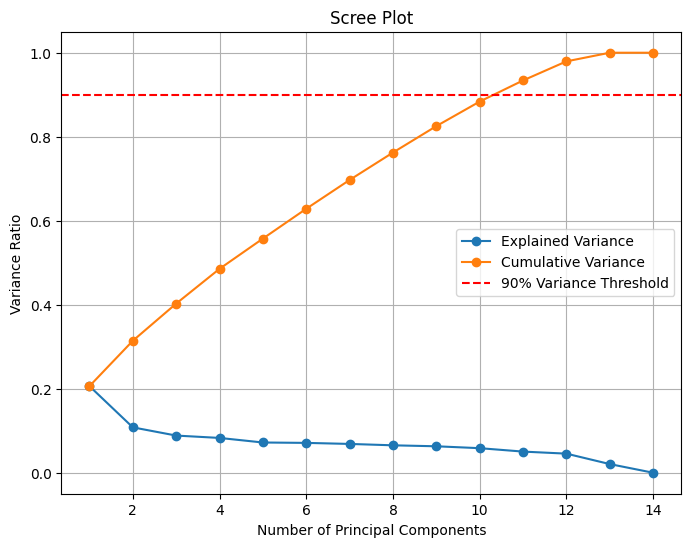

Optimal number of dimensions: 11


In [20]:
X_scaled = scaler.transform(X)
# Perform PCA
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_
cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

# Scree Plot
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(explained_variance_ratio) + 1), explained_variance_ratio, 'o-', label="Explained Variance")
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, 'o-', label="Cumulative Variance")
plt.axhline(y=0.9, color='r', linestyle='--', label="90% Variance Threshold")
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance Ratio')
plt.title('Scree Plot')
plt.legend(loc='best')
plt.grid()
plt.show()

# Determine optimal number of components
optimal_components = np.argmax(cumulative_variance_ratio >= 0.9) + 1
print(f"Optimal number of dimensions: {optimal_components}")

##### Apply PCA on dataset

In [21]:
optimal_pca = PCA(n_components=optimal_components)
X_train_pca = optimal_pca.fit_transform(X_train_scaled)
X_val_pca = optimal_pca.transform(X_test_scaled)
X_test_pca = optimal_pca.transform(X_test_scaled)

print(f"Shape of data after PCA: {X_train_pca.shape}")

Shape of data after PCA: (4088, 11)


##### 6. Repeat step 2 and 4 again with the new dataset after dimensionality reduction with the optimal number of dimensions.

In [22]:
# Define the MLP model
mlp = MLPClassifier(max_iter=500, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'hidden_layer_sizes': [
        (32,), (64,), (128,), (64, 32), (128, 64), (256, 128), (64, 64), (128, 128), (256, 256), (64, 64, 32)
    ],
    'learning_rate_init': [0.0001, 0.001, 0.01]
}
# Perform grid search with cross-validation
grid_search_pca = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=5, scoring='accuracy', verbose=2)
grid_search_pca.fit(X_train_pca, y_train)
# Output the best hyperparameters
print(f"Best Hyperparameters (PCA Reduced Data): {grid_search_pca.best_params_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END hidden_layer_sizes=(32,), learning_rate_init=0.0001; total time=   1.7s
[CV] END hidden_layer_sizes=(32,), learning_rate_init=0.0001; total time=   1.7s
[CV] END hidden_layer_sizes=(32,), learning_rate_init=0.0001; total time=   1.3s
[CV] END hidden_layer_sizes=(32,), learning_rate_init=0.0001; total time=   1.3s
[CV] END hidden_layer_sizes=(32,), learning_rate_init=0.0001; total time=   1.5s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .hidden_layer_sizes=(32,), learning_rate_init=0.001; total time=   2.5s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .hidden_layer_sizes=(32,), learning_rate_init=0.001; total time=   2.6s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .hidden_layer_sizes=(32,), learning_rate_init=0.001; total time=   3.0s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .hidden_layer_sizes=(32,), learning_rate_init=0.001; total time=   2.7s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .hidden_layer_sizes=(32,), learning_rate_init=0.001; total time=   2.8s
[CV] END ..hidden_layer_sizes=(32,), learning_rate_init=0.01; total time=   0.7s
[CV] END ..hidden_layer_sizes=(32,), learning_rate_init=0.01; total time=   0.6s
[CV] END ..hidden_layer_sizes=(32,), learning_rate_init=0.01; total time=   0.6s
[CV] END ..hidden_layer_sizes=(32,), learning_rate_init=0.01; total time=   0.7s
[CV] END ..hidden_layer_sizes=(32,), learning_rate_init=0.01; total time=   0.8s
[CV] END hidden_layer_sizes=(64,), learning_rate_init=0.0001; total time=   1.3s
[CV] END hidden_layer_sizes=(64,), learning_rate_init=0.0001; total time=   1.5s
[CV] END hidden_layer_sizes=(64,), learning_rate_init=0.0001; total time=   1.6s
[CV] END hidden_layer_sizes=(64,), learning_rate_init=0.0001; total time=   1.2s
[CV] END hidden_layer_sizes=(64,), learning_rate_init=0.0001; total time=   4.0s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .hidden_layer_sizes=(64,), learning_rate_init=0.001; total time=   7.5s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .hidden_layer_sizes=(64,), learning_rate_init=0.001; total time=   3.7s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .hidden_layer_sizes=(64,), learning_rate_init=0.001; total time=   3.3s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .hidden_layer_sizes=(64,), learning_rate_init=0.001; total time=   3.5s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END .hidden_layer_sizes=(64,), learning_rate_init=0.001; total time=   3.5s
[CV] END ..hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   1.0s
[CV] END ..hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   1.5s
[CV] END ..hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   1.9s
[CV] END ..hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   1.0s
[CV] END ..hidden_layer_sizes=(64,), learning_rate_init=0.01; total time=   1.2s
[CV] END hidden_layer_sizes=(128,), learning_rate_init=0.0001; total time=   2.0s
[CV] END hidden_layer_sizes=(128,), learning_rate_init=0.0001; total time=   1.7s
[CV] END hidden_layer_sizes=(128,), learning_rate_init=0.0001; total time=   1.8s
[CV] END hidden_layer_sizes=(128,), learning_rate_init=0.0001; total time=   1.5s
[CV] END hidden_layer_sizes=(128,), learning_rate_init=0.0001; total time=   1.5s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128,), learning_rate_init=0.001; total time=   4.8s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128,), learning_rate_init=0.001; total time=   4.6s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128,), learning_rate_init=0.001; total time=   5.2s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128,), learning_rate_init=0.001; total time=   4.7s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128,), learning_rate_init=0.001; total time=   4.6s
[CV] END .hidden_layer_sizes=(128,), learning_rate_init=0.01; total time=   1.5s
[CV] END .hidden_layer_sizes=(128,), learning_rate_init=0.01; total time=   1.6s
[CV] END .hidden_layer_sizes=(128,), learning_rate_init=0.01; total time=   1.1s
[CV] END .hidden_layer_sizes=(128,), learning_rate_init=0.01; total time=   1.4s
[CV] END .hidden_layer_sizes=(128,), learning_rate_init=0.01; total time=   1.6s
[CV] END hidden_layer_sizes=(64, 32), learning_rate_init=0.0001; total time=   1.9s
[CV] END hidden_layer_sizes=(64, 32), learning_rate_init=0.0001; total time=   1.5s
[CV] END hidden_layer_sizes=(64, 32), learning_rate_init=0.0001; total time=   1.4s
[CV] END hidden_layer_sizes=(64, 32), learning_rate_init=0.0001; total time=   1.2s
[CV] END hidden_layer_sizes=(64, 32), learning_rate_init=0.0001; total time=   1.5s
[CV] END hidden_layer_sizes=(64, 32), learning_rate_init=0.001; total time=   4.1s
[CV] END hi

d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 32), learning_rate_init=0.001; total time=   5.0s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 32), learning_rate_init=0.001; total time=   5.5s
[CV] END hidden_layer_sizes=(64, 32), learning_rate_init=0.001; total time=   4.6s
[CV] END hidden_layer_sizes=(64, 32), learning_rate_init=0.01; total time=   1.0s
[CV] END hidden_layer_sizes=(64, 32), learning_rate_init=0.01; total time=   0.9s
[CV] END hidden_layer_sizes=(64, 32), learning_rate_init=0.01; total time=   1.1s
[CV] END hidden_layer_sizes=(64, 32), learning_rate_init=0.01; total time=   1.0s
[CV] END hidden_layer_sizes=(64, 32), learning_rate_init=0.01; total time=   1.0s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.0001; total time=  13.3s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.0001; total time=  12.7s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.0001; total time=  12.4s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.0001; total time=  14.7s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.0001; total time=  14.6s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.001; total time=   8.8s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.001; total time=   9.5s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.001; total time=   9.3s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.001; total time=  11.8s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.001; total time=  10.9s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.01; total time=   2.2s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.01; total time=   3.0s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.01; total time=   2.6s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.01; total time=   2.8s
[CV] END hidden_layer_sizes=(128, 64), learning_rate_init=0.01; total time=   3.0s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.0001; total time=  24.6s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.0001; total time=  26.3s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.0001; total time=  29.8s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.0001; total time=  28.4s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.0001; total time=  27.9s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.001; total time=  10.6s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.001; total time=  11.6s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.001; total time=  10.3s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.001; total time=   7.9s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.001; total time=  12.6s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.01; total time=   4.5s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.01; total time=   5.6s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.01; total time=   5.2s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.01; total time=   6.1s
[CV] END hidden_layer_sizes=(256, 128), learning_rate_init=0.01; total time=   5.0s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.0001; tota

d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.0001; total time=   7.0s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.0001; total time=   2.7s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.0001; total time=   6.8s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.0001; total time=   2.5s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.001; total time=   6.8s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.001; total time=   5.1s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.001; total time=   6.5s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.001; total time=   5.7s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.001; total time=   6.9s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.01; total time=   2.1s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.01; total time=   1.9s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.01; total time=   1.2s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.01; total time=   1.9s
[CV] END hidden_layer_sizes=(64, 64), learning_rate_init=0.01; total time=   1.4s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.0001; total time=  26.5s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.0001; total time=  18.3s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.0001; total time=  18.3s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.0001; total time=  19.4s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.0001; total time=  19.7s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.001; total time=  13.4s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.001; total time=   8.6s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.001; total time=   7.8s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.001; total time=   8.1s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.001; total time=   9.7s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.01; total time=   2.7s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.01; total time=   3.8s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.01; total time=   3.6s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.01; total time=   3.3s
[CV] END hidden_layer_sizes=(128, 128), learning_rate_init=0.01; total time=   2.2s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(256, 256), learning_rate_init=0.0001; total time=  36.5s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(256, 256), learning_rate_init=0.0001; total time=  29.7s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(256, 256), learning_rate_init=0.0001; total time=  30.4s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(256, 256), learning_rate_init=0.0001; total time=  29.7s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(256, 256), learning_rate_init=0.0001; total time=  29.8s
[CV] END hidden_layer_sizes=(256, 256), learning_rate_init=0.001; total time=  11.7s
[CV] END hidden_layer_sizes=(256, 256), learning_rate_init=0.001; total time=  10.3s
[CV] END hidden_layer_sizes=(256, 256), learning_rate_init=0.001; total time=  10.0s
[CV] END hidden_layer_sizes=(256, 256), learning_rate_init=0.001; total time=  11.7s
[CV] END hidden_layer_sizes=(256, 256), learning_rate_init=0.001; total time=  10.6s
[CV] END hidden_layer_sizes=(256, 256), learning_rate_init=0.01; total time=   5.1s
[CV] END hidden_layer_sizes=(256, 256), learning_rate_init=0.01; total time=   7.6s
[CV] END hidden_layer_sizes=(256, 256), learning_rate_init=0.01; total time=   4.2s
[CV] END hidden_layer_sizes=(256, 256), learning_rate_init=0.01; total time=   4.7s
[CV] END hidden_layer_sizes=(256, 256), learning_rate_init=0.01; total time=   5.6s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.0001; total time=   8.1s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.0001; total time=   8.2s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.0001; total time=   8.2s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.0001; total time=   8.4s


d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.0001; total time=   8.1s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.001; total time=   3.1s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.001; total time=   2.9s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.001; total time=   3.1s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.001; total time=   3.4s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.001; total time=   2.8s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.01; total time=   1.4s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.01; total time=   1.0s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.01; total time=   1.3s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.01; total time=   1.5s
[CV] END hidden_layer_sizes=(64, 64, 32), learning_rate_init=0.01; total time=   1.1s
Best Hyperparameters (PCA Reduced Data): {'hidd

##### Eveluate model

In [23]:
# Best model from Grid Search
best_model_pca = grid_search_pca.best_estimator_

# Predict on test set
y_test_pred_pca = best_model_pca.predict(X_test_pca)

# Evaluate the F1-Score
f1_pca = f1_score(y_test, y_test_pred_pca, average='weighted')
print(f"F1-Score on Test Set after PCA: {f1_pca:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_pca))

F1-Score on Test Set after PCA: 0.9100

Classification Report:
              precision    recall  f1-score   support

           0       0.94      1.00      0.97       960
           1       0.00      0.00      0.00        62

    accuracy                           0.94      1022
   macro avg       0.47      0.50      0.48      1022
weighted avg       0.88      0.94      0.91      1022



d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Conestoga\CSCN8000-AIAM\CSCN8000\venvCSCN8000\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.

##### 7. Compare and comment on the outputs of Step 4 and 6 and determine whether dimensionality reduction lead to performance enhancement.

- As F1 Score before and after the PCA is same. it shows that PCA did not affect model performance. This also indicates that dimensionality reduction remained essential information required for the classification. 
- The MLP model effectively captured the patterns in first training and it was not negatively affected by higher dimensions.
- PCA reduced complexity and computational cost which made training faster
